In [2]:
import tensorflow as t
import os

import cv2
import numpy as np
from matplotlib import pyplot as plt

# Importar dependencias para el modelo
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

# Importar dependencias para guardar el modelo
from tensorflow.python.keras.models import save_model, load_model

from keras.applications import imagenet_utils
from tensorflow import Tensor

from PIL import Image as im


In [95]:
data_dir = 'data-adversarial-training'

# Mostrar una imagen con matplotlib usando cv2 para corregir los colores
def mostrarImagen(img: cv2.typing.MatLike):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [96]:
datos = t.keras.utils.image_dataset_from_directory(
    data_dir,
    batch_size=32,  # Tamaño de lote de datos
)
# Creamos un iterador para recorrer los datos
iterador_datos = datos.as_numpy_iterator()
lote_datos = iterador_datos.next() # Si tenemos error implica que las imágenes tienen formatos incorrectos.

Found 693 files belonging to 4 classes.


In [ ]:
lote_datos # (imagenes, etiquetas)

In [8]:
# Diccionario de etiquetas
nombre_etiqueta = {
    0: 'Señal Máx. 120Km/h',
    1: 'Señal Máx. 50Km/h',
    2: 'Señal Radar',
    3: 'Señal STOP'
}

def mostrarPrediccion(yhat: np.ndarray,img):

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Prediccion: {}'.format(nombre_etiqueta[np.argmax(yhat)]))
    plt.show()

In [105]:
datos = datos.map(lambda x,y: (x/255, y))

In [129]:
iterador_datos = datos.as_numpy_iterator()
lote_datos = iterador_datos.next()

In [ ]:
lote_datos

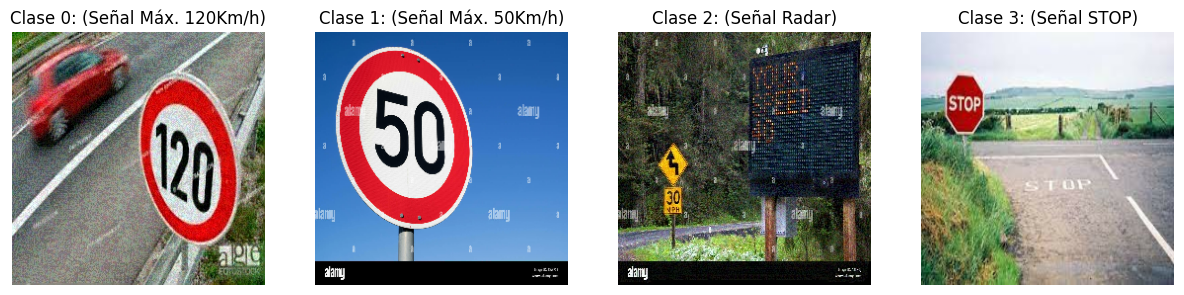

In [130]:
# Mostrar las clases de las imágenes con ejemplo
fig, axs = plt.subplots(1, 4, figsize=(15, 15),sharey=True)

for i in range(4):
    idnx = list(lote_datos[1]).index(i)
    img = lote_datos[0][idnx]
    axs[i].imshow(img * 255.0)
    clase = lote_datos[1][idnx]
    axs[i].set_title('Clase {}: ({})'.format(clase,nombre_etiqueta[clase]))
    axs[i].axis('off')

In [ ]:
size_entrenamiento = int(len(datos) * 0.7)
size_validacion = int(len(datos) * 0.15) + 1
size_test = int(len(datos) * 0.15) + 1

#len(datos) == size_entrenamiento + size_validacion + size_test

In [ ]:
particion_entrenamiento = datos.take(size_entrenamiento)
particion_validacion = datos.skip(size_entrenamiento).take(size_validacion)
particion_test = datos.skip(size_entrenamiento + size_validacion)

In [ ]:
modelo  = Sequential() # Inicializar el modelo

In [ ]:
modelo.add(Conv2D(16, (3, 3),1 , activation='relu', input_shape=(256, 256, 3))) # Capa de convolución
modelo.add(MaxPooling2D()) # Capa de pooling

modelo.add(Conv2D(32, (3, 3),1 , activation='relu')) # Capa de convolución
modelo.add(MaxPooling2D()) # Capa de pooling

modelo.add(Conv2D(16, (3, 3),1 , activation='relu')) # Capa de convolución
modelo.add(MaxPooling2D()) # Capa de pooling

modelo.add(Flatten()) # Aplanar la imagen

modelo.add(Dense(256, activation='relu')) # Capa densa
modelo.add(Dense(4, activation='softmax')) # Capa densa

In [ ]:
# Compilar el modelo
modelo.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Ver las estadísticas del modelo generado
modelo.summary()

In [ ]:
# Seleccionar directorio para guardar los logs
logs_dir = 'logs-adversarial-training'
tensorboard_callback = t.keras.callbacks.TensorBoard(log_dir=logs_dir, histogram_freq=1)

In [ ]:
# Entrenar el modelo y guardar los logs
hist = modelo.fit(particion_entrenamiento, validation_data=particion_validacion, epochs=50, callbacks=[tensorboard_callback])

In [ ]:
# Evaluar la precisión del modelo
fig = plt.figure()
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

In [1]:
modelo.save(os.path.join('models','SignAdversaryTrainedClassifier.h5'))

NameError: name 'modelo' is not defined

Cargar modelo

In [3]:
modelo = load_model(os.path.join('models','SignAdversaryTrainedClassifier.h5'))

Testeo

In [4]:
image_path = 'sign-50.jpg'

In [5]:
img = cv2.imread(image_path)
resize = t.image.resize(img, [256, 256])

In [6]:
yhat = modelo.predict(np.expand_dims(resize/255, axis=0))

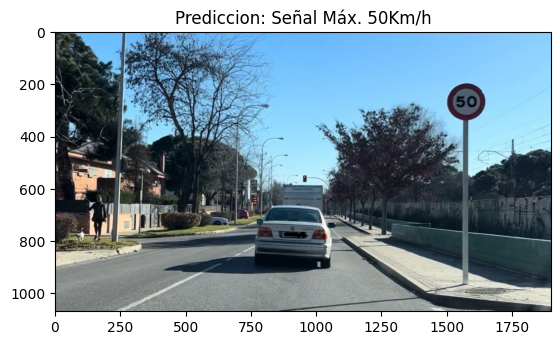

In [9]:
mostrarPrediccion(yhat,img)

In [10]:
class FGSMAttack():

    def __init__(self, source_image_path: str, epsilon : float, input_label: int) -> None:

        """
        Clase que implementa el ataque FGSM (Fast Gradient Sign Method) para generar una imagen adversarial.

        Atributos:
        - source_image_path: Ruta de la imagen original.
        - epsilon: Valor de la perturbación.
        - input_label: Etiqueta de la clase objetivo.
        - source_image: Imagen original preprocesada.
        - loss_object: Función de pérdida utilizada para el ataque.
        - adversarial_pattern: Patrón adversario generado.
        - adversarial_image: Imagen adversaria generada.
        
        """

        self.epsilon = epsilon
        self.input_label = self.__get_label(input_label)

        self.source_image = self.__preprocess_image(source_image_path)
        self.pretrained_model = modelo

        self.loss_object = t.keras.losses.CategoricalCrossentropy()
        
        self.adversarial_pattern = self.__generate_adversarial_pattern()

        self.adversarial_image = self.__generate_adversarial_image()

    def __preprocess_image(self, image_path: str) -> Tensor:
        image_raw = t.io.read_file(image_path)
        image = t.image.decode_image(image_raw)
        image = t.cast(image, t.float32)
        image = self.__resize_image(image)
        image = image[None, ...]

        image = imagenet_utils.preprocess_input(
            image, data_format=None, mode="tf"
        )

        return image
    
    def __resize_image(self, image: Tensor) -> Tensor:
        return t.image.resize(image, [256, 256])

    def __generate_adversarial_image(self) -> Tensor:
        adv_img = self.source_image + (self.epsilon * self.adversarial_pattern)
        adv_img = t.clip_by_value(adv_img, -1, 1)
        return adv_img

    def __generate_adversarial_pattern(self) -> Tensor:
        with t.GradientTape() as tape:
            tape.watch(self.source_image)
            prediction = self.pretrained_model(self.source_image)
            loss = self.loss_object(self.input_label, prediction)

        # Get the gradients of the loss w.r.t to the input image.
        gradient = tape.gradient(loss, self.source_image)
        # Get the sign of the gradients to create the perturbation
        signed_grad = t.sign(gradient)
        
        return signed_grad
    
    def get_adversarial_image(self) -> Tensor:
        return self.adversarial_image
    
    def get_adversarial_pattern(self) -> Tensor:
        return self.adversarial_pattern
    
    def get_source_image(self) -> Tensor:
        return self.source_image
    
    def __get_label(self, class_index: int) -> Tensor:
        label = t.one_hot(class_index, 4)
        label = t.reshape(label, (1, 4))

        return label
    

In [16]:
# Añadir ruido a la imagen
class_index = 0

label = t.one_hot(class_index, 4)
label = t.reshape(label, (1, 4))

epsilon = 0.015

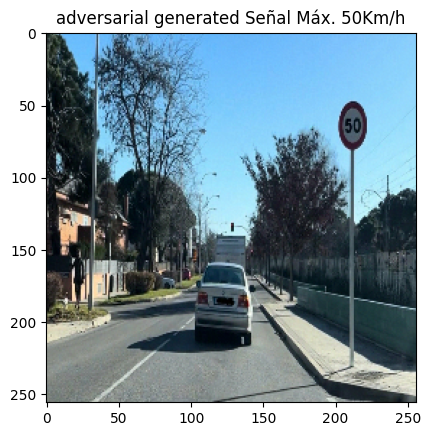

In [17]:
attack = FGSMAttack(image_path, epsilon, int(np.argmax(yhat)))
adversarial_image = attack.get_adversarial_image()

image_np = adversarial_image.numpy()

predictions_adv = modelo.predict(image_np)

adversarial_image = im.fromarray(((image_np[0] + 1) * 127.5).astype("uint8"))
plt.title("adversarial generated " + nombre_etiqueta[np.argmax(predictions_adv)]) 
plt.imshow(adversarial_image)

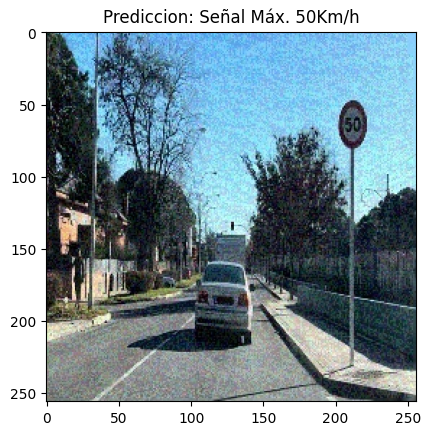

In [13]:
# Obtener la imagen adversaria

img_advs = img = cv2.imread('adversarial_50.jpg')
resize = t.image.resize(img, [256, 256])

yhat = modelo.predict(np.expand_dims(resize/255, axis=0))

mostrarPrediccion(yhat,img)